# Bike Sharing Dataset
The dataset contains the hourly count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.
- 13 features
- 17389 instances

In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import time

from math import sqrt
from math import log
from scipy.stats import skew

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor as SklearnRandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid, KFold

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading Configuration and Data

In [2]:
from utils.data_loader import load_config
from utils.evaluation import  evaluate_model, draw_histograms, plot_results
from utils.modelling import RegressionTreeScratch,  RegressionTreeLLM, RandomForestRegressorLLM, RandomForestRegressorScratch, grid_search_custom_model_parallel

In [3]:
config = load_config("config.yaml")
# Read the data path for Bike Sharing dataset
data_path = config['paths']['bikes_hourly']
columns = [
    "instant", "dteday", "season", "yr", "mnth", "hr", "holiday",
    "weekday", "workingday", "weathersit", "temp", "atemp", "hum",
    "windspeed", "casual", "registered", "cnt"
]

# Read the dataset
hour_data = pd.read_csv(data_path)

data_path = config['paths']['bikes_daily']
columns = [
    "instant", "dteday", "season", "yr", "mnth", "holiday",
    "weekday", "workingday", "weathersit", "temp", "atemp", "hum",
    "windspeed", "casual", "registered", "cnt"
]

# Read the dataset
day_data = pd.read_csv(data_path)

### Data Analysis

In [4]:
print(hour_data.head())
print(day_data.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01   

In [5]:
hour_data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [6]:
day_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [7]:
print(hour_data.shape)
print(day_data.shape)  

(17379, 17)
(731, 16)


In [8]:
print(hour_data.isna().sum())  #expecting 0 missing values
print(day_data.isna().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [9]:
day_data.dtypes
hour_data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Explaination of Attributes by Data Metadata
- instant: record index
	- dteday : date
	- season : season (1:winter, 2:spring, 3:summer, 4:fall)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
	- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

##### Target Analysis

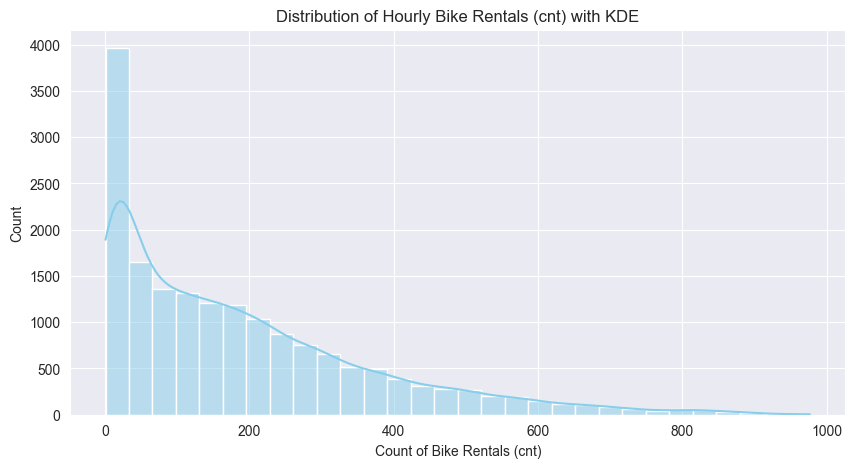

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(hour_data['cnt'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Hourly Bike Rentals (cnt) with KDE')
plt.xlabel('Count of Bike Rentals (cnt)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


The histogram shows a right-skewed distribution. The majority of the bike rentals occur at lower counts, with the frequency tapering off as the count increases.
- There is a significant peak at 0 rentals, indicating that there are many hours with no bike rentals.

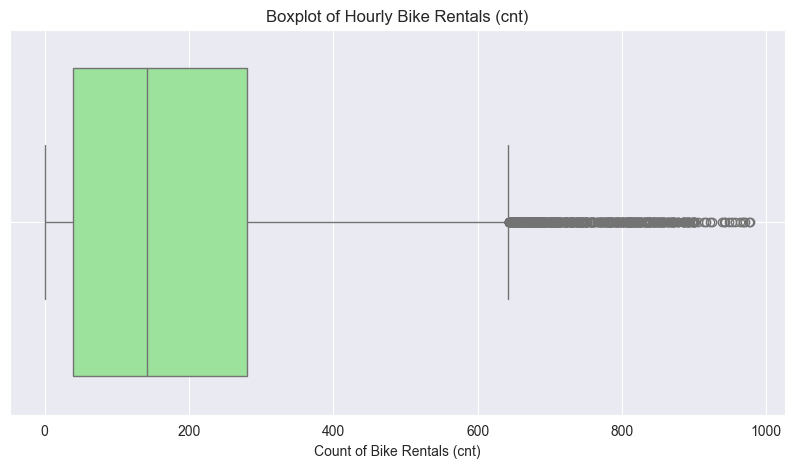

In [11]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=hour_data['cnt'], color='lightgreen')
plt.title('Boxplot of Hourly Bike Rentals (cnt)')
plt.xlabel('Count of Bike Rentals (cnt)')
plt.grid(True)
plt.show()

Most bike rentals occur within a specific range, but there are notable exceptions (outliers) that reflect periods of high demand.

##### Graphical Analysis of Attributes

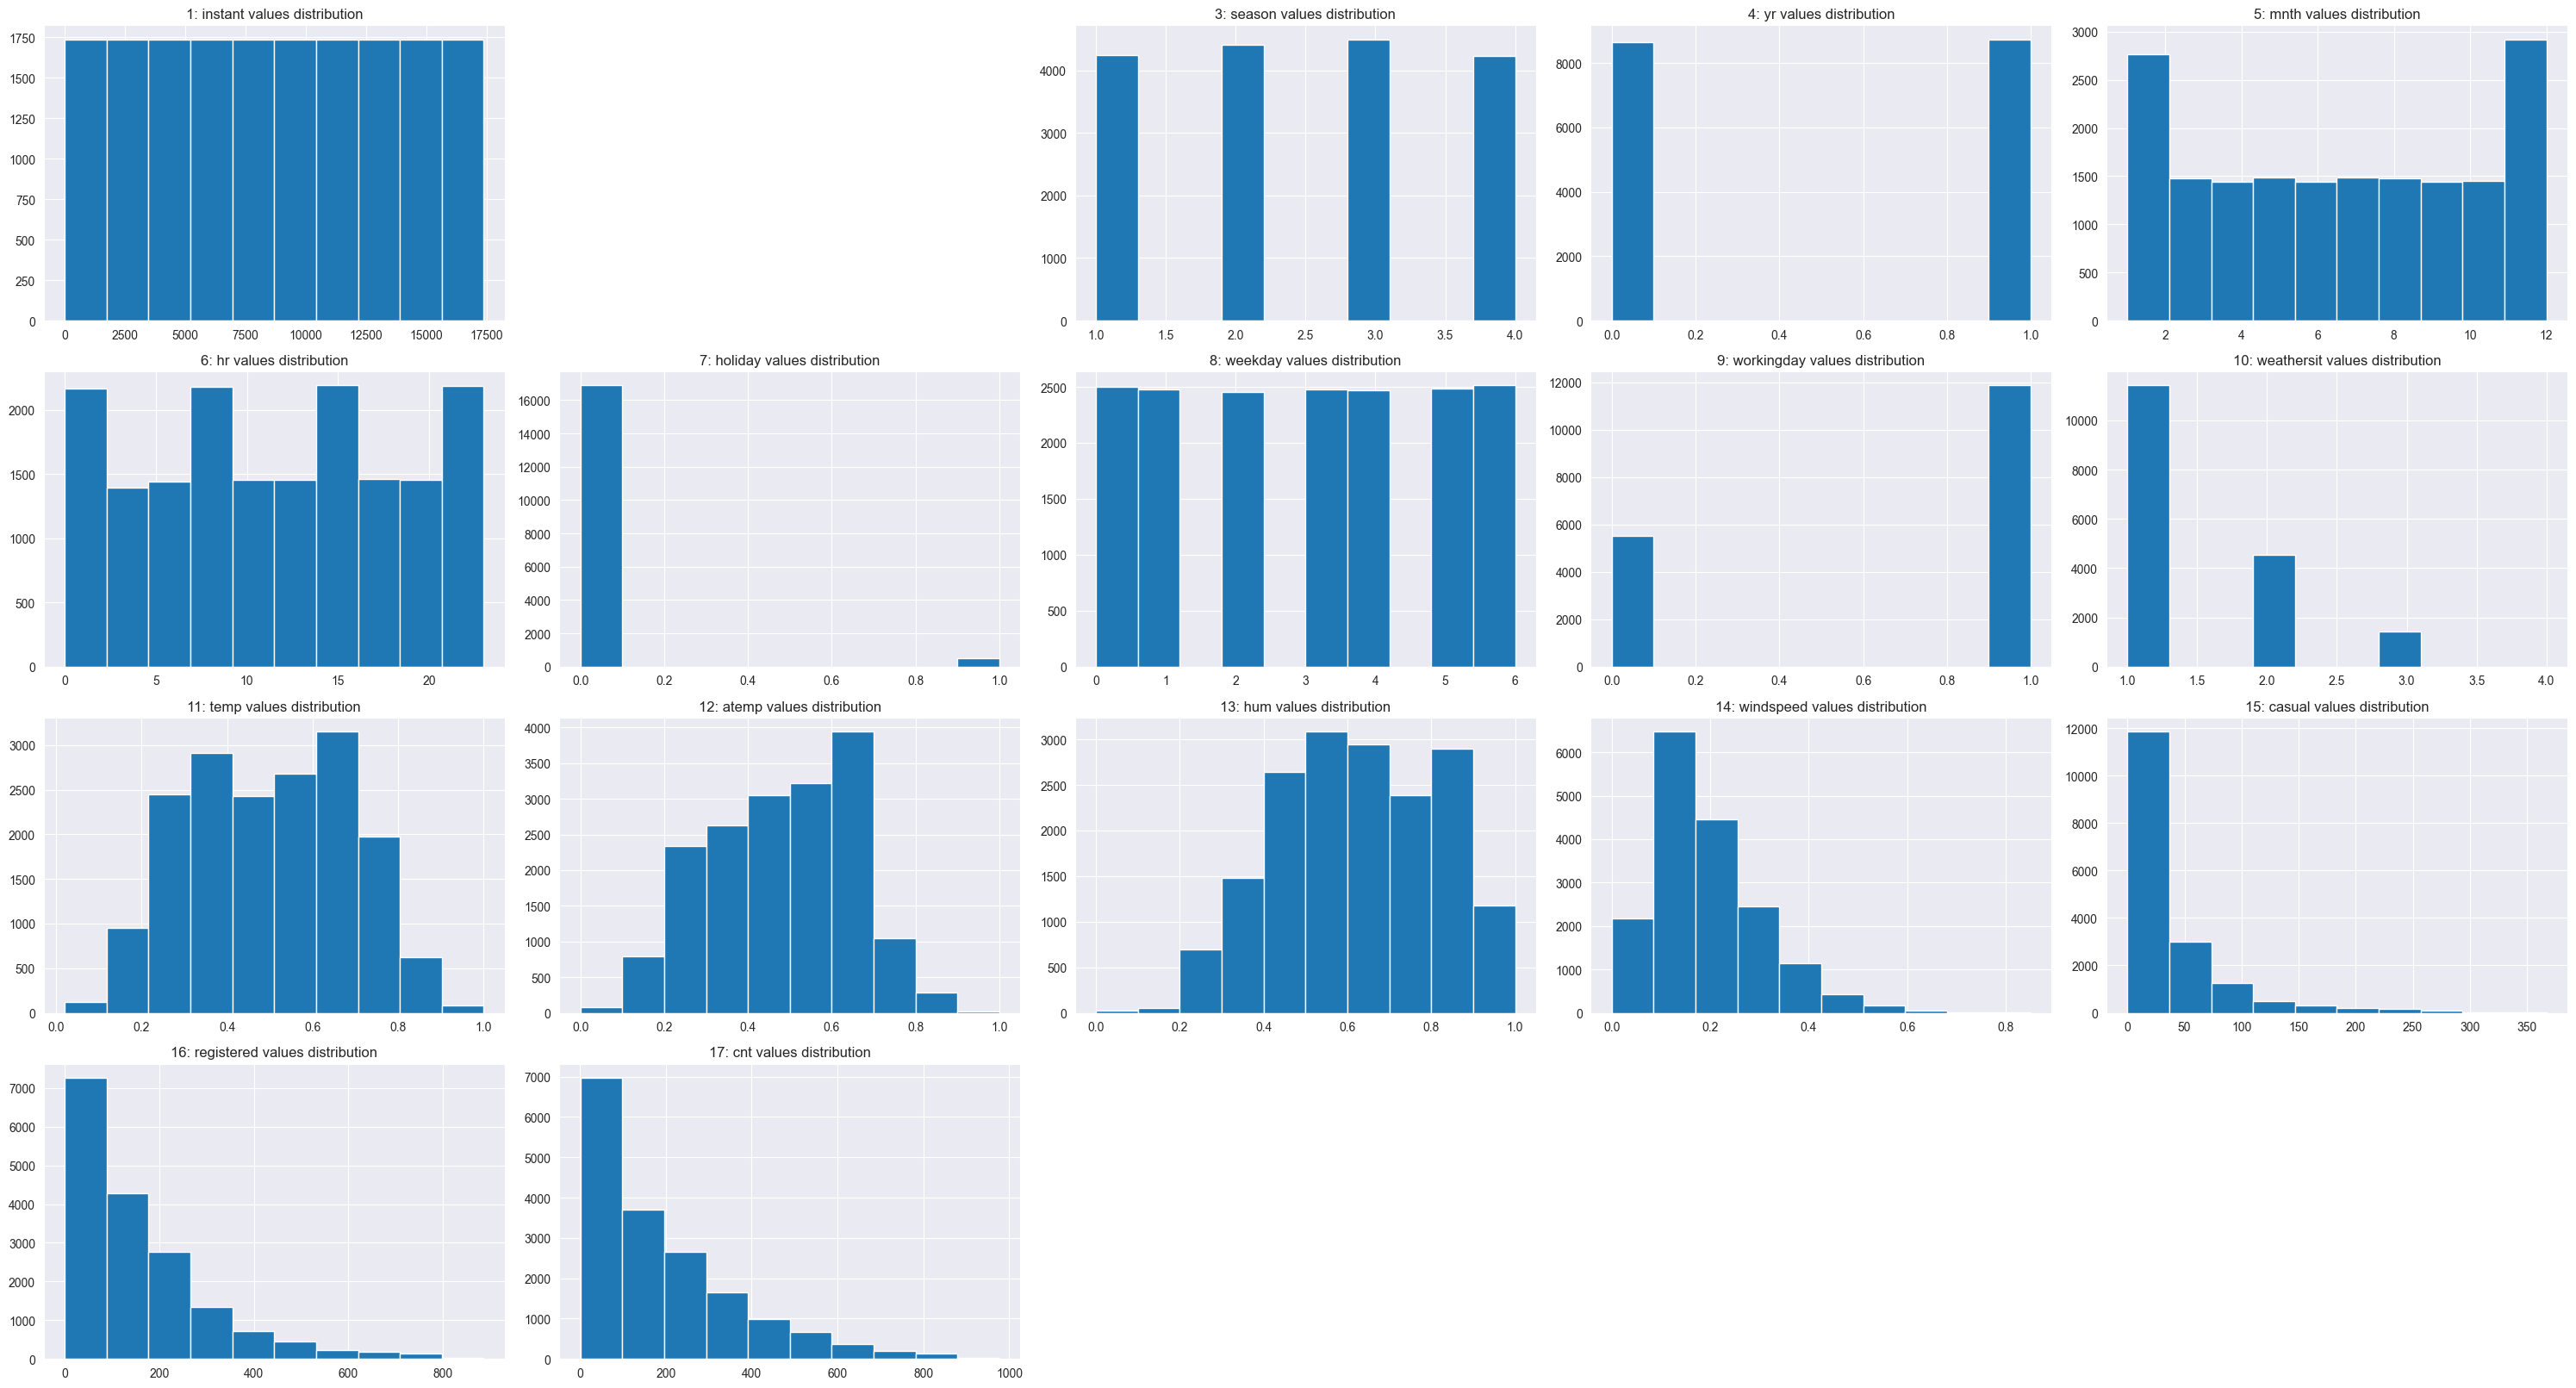

In [12]:
draw_histograms(hour_data)

##### Analysis of histograms 

- Some histograms show skewed distributions. For example, bike rental counts where most of the values are lower and only a few instances have high rentals. This indicates that on most days/hours, rentals are moderate, but on a few occasions, rentals spike.
- The temperature and humidity distributions appear more normal (bell-shaped), especially for temp or atemp. These are continuous variables and follow a more normal distribution 
hour_data

##### Numerical Variables Analysis 
Analysis of Skewness

Skewness of numerical variables:
 casual        2.499021
registered    1.557770
temp         -0.006020
hum          -0.111278
windspeed     0.574856
dtype: float64


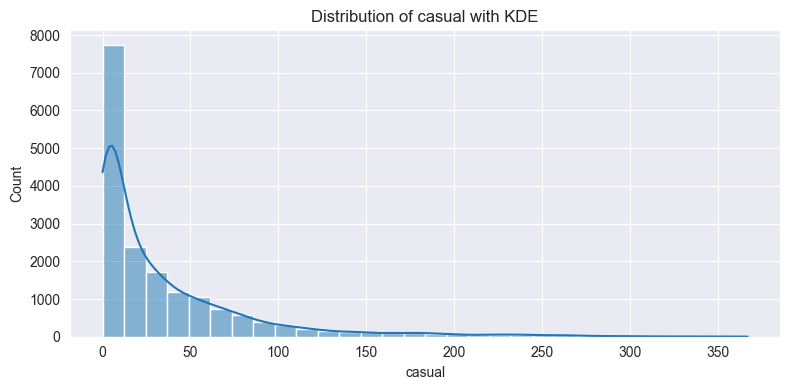

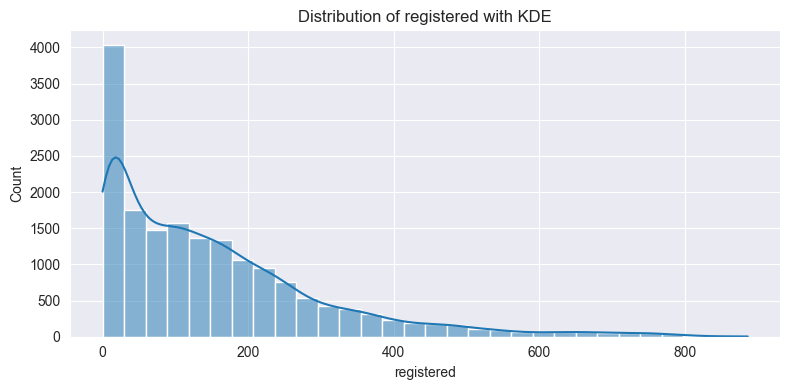

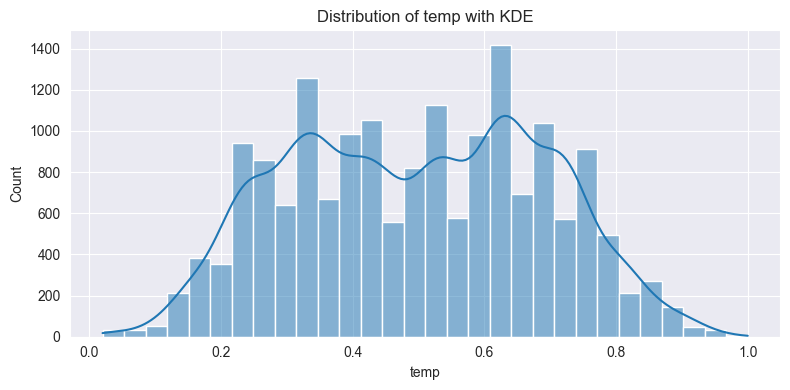

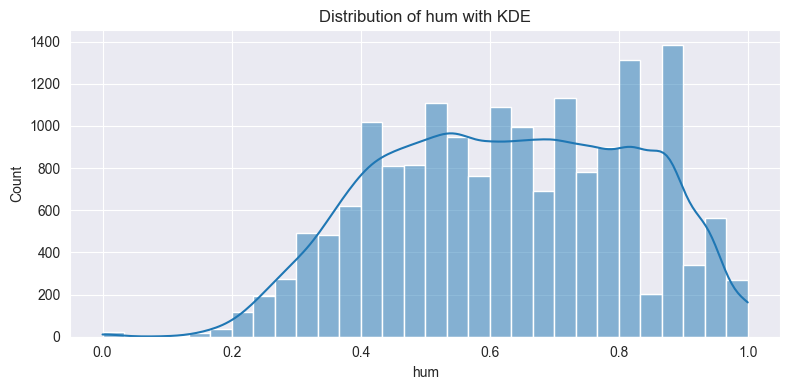

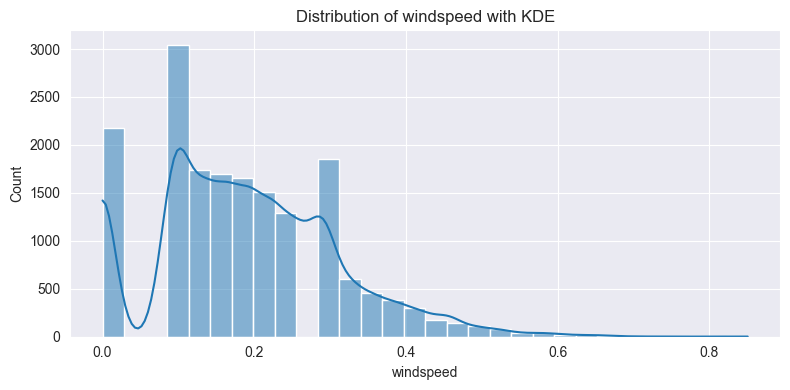

In [13]:
numerical_f = ['casual', 'registered', 'temp', 'hum', 'windspeed']
skewness_values = hour_data[numerical_f].apply(skew)
print("Skewness of numerical variables:\n", skewness_values)

for col in numerical_f:
    plt.figure(figsize=(8, 4))
    sns.histplot(hour_data[col], bins=30, kde=True)
    plt.title(f"Distribution of {col} with KDE")
    plt.tight_layout()
    plt.show()


- The majority of casual users rent fewer bikes, but occasionally, there are spikes in casual bike usage.
- The distributions suggest that low wind speeds likely encourage bike rentals.

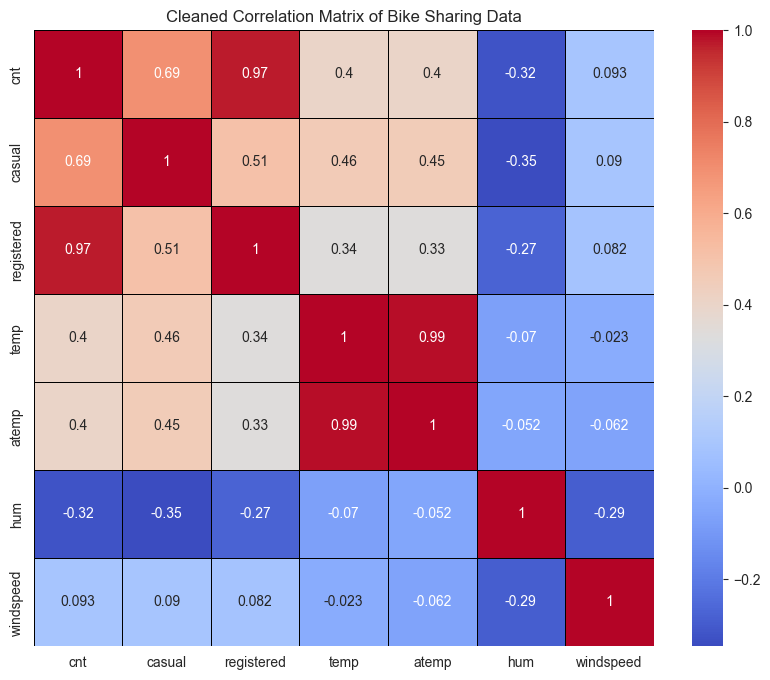

In [14]:
numerical_columns = ['cnt', 'casual', 'registered', 'temp', 
                             'atemp', 'hum', 'windspeed']
correlation_matrix_cleaned = hour_data[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Cleaned Correlation Matrix of Bike Sharing Data')
plt.show()

- Correlation of 0.97 between cnt and registered, 0.69 between cnt and casual shows that when registered users rent more bikes, casual rent more as well, and vice versa.
- Moderate positive correlation (0.40) between bike rentals (cnt) and temperature (temp) shows that higher temperatures is somewhat associated with higher bike rentals. However, this correlation is not extremely strong, indicating that other factors determine bike rentals.
- Weak negative correlation between humidity and bike rentals (cnt: -0.32, casual_hourly: -0.35, registered_hourly: -0.27) meaning higher humidity is associated with fewer bike rentals.

Suggestions
-  We can drop one of temp_hourly and atemp_hourly in the predictive modeling later on to avoid multicollinearity.

##### Categorical Variables Analysis 

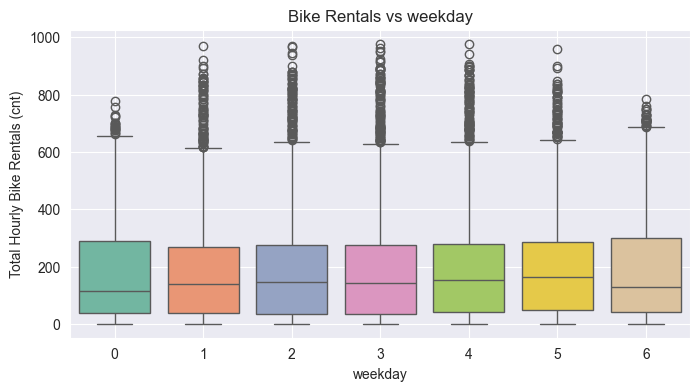

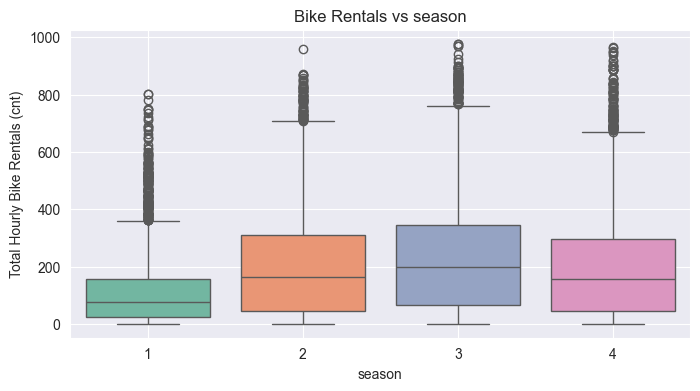

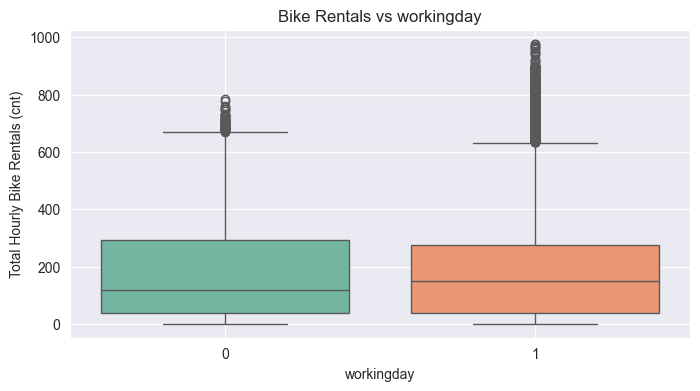

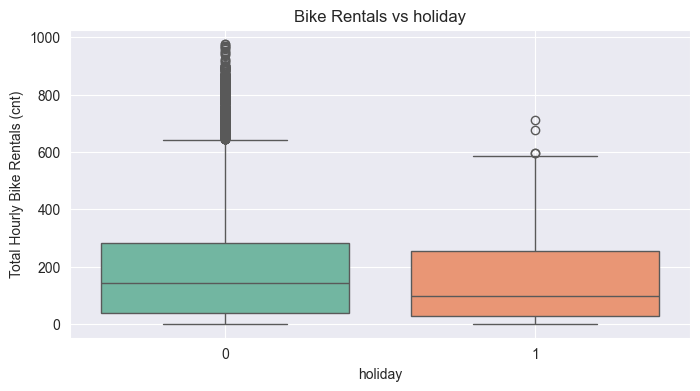

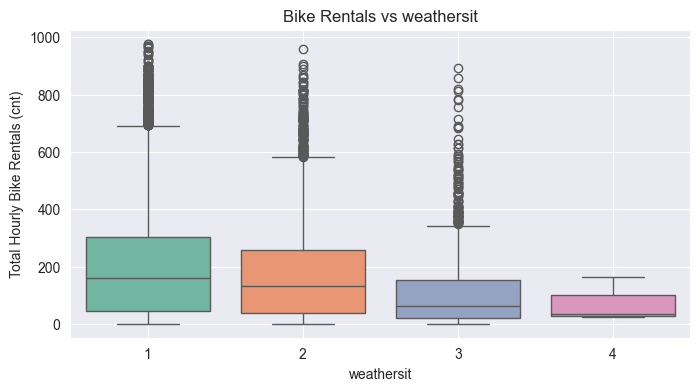

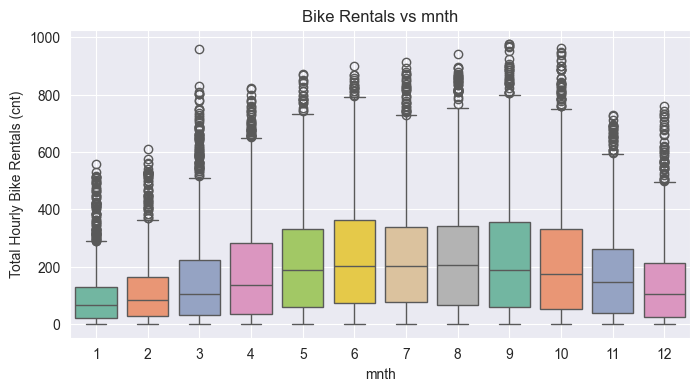

In [15]:
categorical_f = ['weekday','season', 'workingday', 'holiday', 'weathersit', 'mnth']
for col in categorical_f:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=hour_data[col], y=hour_data['cnt'], palette='Set2')
    plt.title(f'Bike Rentals vs {col}')
    plt.xlabel(col)
    plt.ylabel('Total Hourly Bike Rentals (cnt)')
    plt.grid(True)
    plt.show()

1. Bike Rentals vs. weathersit_hourly: Clear weather significantly boosts bike rentals, while rainy conditions lead to a marked decrease.
2. Bike Rentals vs. holiday_hourly: Bike rentals are higher on working days compared to holidays, indicating a strong commuting trend.
3. Bike Rentals vs. workingday_hourly: Warm weather in spring and summer encourages biking, whereas winter leads to reduced rentals.
4. Bike Rentals vs. season_hourly: Weekdays see more rentals than weekends, emphasizing biking for commuting over leisure on working days.

Hourly Distribution Analysis

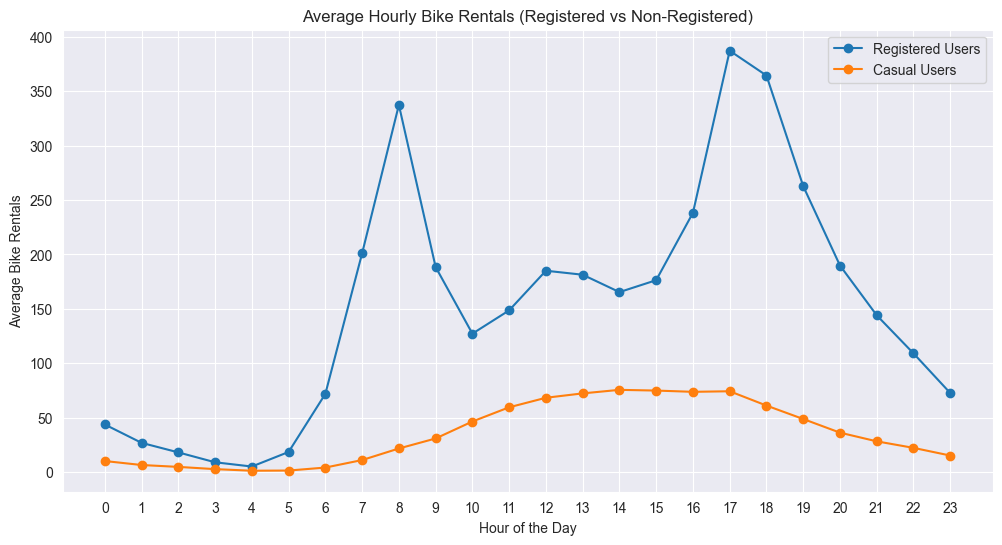

In [16]:
hourly_group = hour_data.groupby('hr')[['registered', 'casual']].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_group.index, hourly_group['registered'], label='Registered Users', marker='o')
plt.plot(hourly_group.index, hourly_group['casual'], label='Casual Users', marker='o')
plt.title('Average Hourly Bike Rentals (Registered vs Non-Registered)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Bike Rentals')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

- spikes during rush hours (around 8am and 17pm) are much more evident in registerd users than casual

Monthly Distributions Analysis

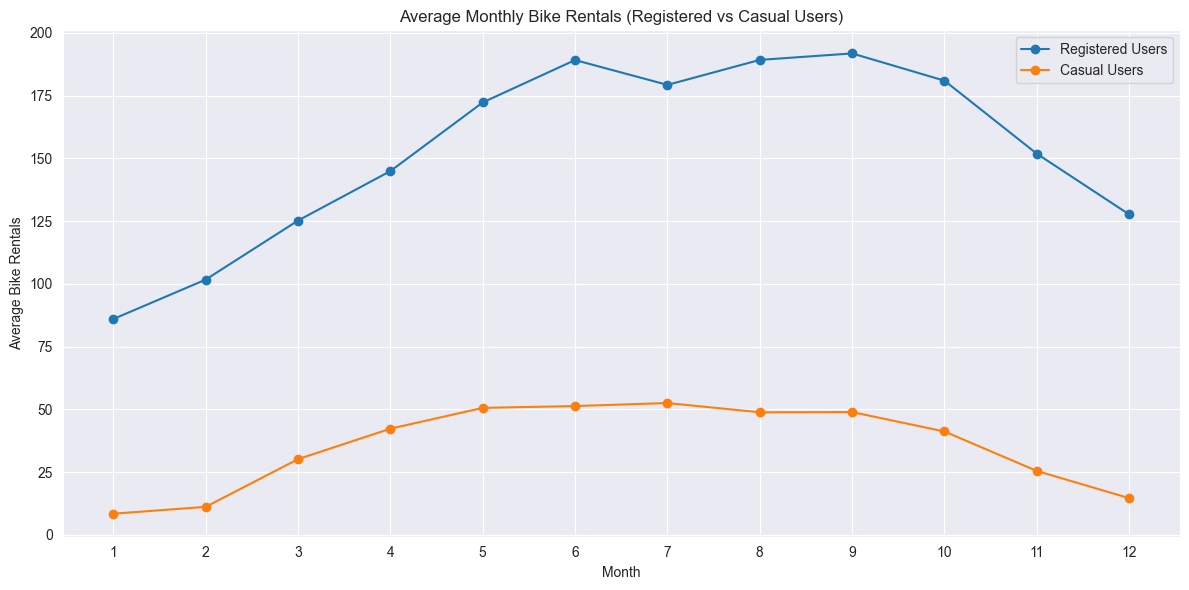

In [17]:
hour_data['dteday'] = pd.to_datetime(hour_data['dteday'])

hour_data['month'] = hour_data['dteday'].dt.month

monthly_group = hour_data.groupby('month')[['registered', 'casual']].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_group.index, monthly_group['registered'], label='Registered Users', marker='o')
plt.plot(monthly_group.index, monthly_group['casual'], label='Casual Users', marker='o')
plt.title('Average Monthly Bike Rentals (Registered vs Casual Users)')
plt.xlabel('Month')
plt.ylabel('Average Bike Rentals')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Data Splitting & Preprocessing

In [18]:
# Dropping columns
bike_data = hour_data.drop(columns=['instant', 'atemp', 'dteday', 'yr'],axis=1)

In [19]:
#Encoding categorical variables
bike_data = pd.get_dummies(bike_data, columns = categorical_f,drop_first=True)
bike_data.head()

,hr,temp,hum,windspeed,casual,registered,cnt,month,weekday_1,weekday_2,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,0,0.24,0.81,0.0,3,13,16,1,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0.22,0.80,0.0,8,32,40,1,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,0.22,0.80,0.0,5,27,32,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,0.24,0.75,0.0,3,10,13,1,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,0.24,0.75,0.0,0,1,1,1,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
bike_data['cnt'].describe()
print(bike_data.columns)

Index(['hr', 'temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt',
       'month', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'season_2', 'season_3', 'season_4',
       'workingday_1', 'holiday_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6',
       'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')


In [21]:
X = bike_data.drop('cnt', axis=1)
y = bike_data['cnt']

In [22]:
test_size = config['split']['test_size']
validation_size = config['split']['validation_size']
random_state = config['split']['random_state']

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state
)
val_size_relative = validation_size / (1 - test_size)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_size_relative,
    random_state=random_state
)
print(X_train.shape[0])
print(X_val.shape[0])
print(X_test.shape[0])

12165
1738
3476


## Modelling

In [24]:
custom_rf_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5,10,20],
    'min_samples_split': [2,5],
    'max_features': ['sqrt', 'log2']
}

#### Random Forest Regression tree from Scratch

In [25]:
# Perform grid search for custom RF
best_custom_rf_params, best_custom_rf_score, custom_rf_results = grid_search_custom_model_parallel(
    RandomForestRegressorScratch, custom_rf_param_grid, X_train.values, y_train.values, cv=5
)

In [27]:

# Train the best Custom RF on the entire training set
best_custom_rf = RandomForestRegressorScratch(**best_custom_rf_params)
best_custom_rf.fit(X_train.values, y_train.values)


#### LLM Random Forest Regression tree from Scratch

In [28]:
# LLM Random Forest
llm_rf_param_grid = custom_rf_param_grid  # Same parameter grid as Custom RF
best_llm_rf_params, best_llm_rf_score, llm_rf_results = grid_search_custom_model_parallel(
    RandomForestRegressorLLM, llm_rf_param_grid, X_train.values, y_train.values, cv = 5
)

In [30]:
# Train the best LLM RF on the entire training set
best_llm_rf = RandomForestRegressorLLM(**best_llm_rf_params)
best_llm_rf.fit(X_train.values, y_train.values)

#### Random forest from Sklearn

In [31]:
# Sklearn Random Forest with GridSearchCV
rf_grid = GridSearchCV(SklearnRandomForestRegressor(random_state=random_state), custom_rf_param_grid, cv=5)
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_

#### Linear Regression

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Prediction

In [33]:
custom_rf_test_metrics = evaluate_model(y_test, best_custom_rf.predict(X_test.values))
llm_rf_test_metrics = evaluate_model(y_test, best_llm_rf.predict(X_test.values))
rf_test_metrics = evaluate_model(y_test, best_rf_model.predict(X_test))
lr_test_metrics = evaluate_model(y_test, lr.predict(X_test))

## Evaluation

In [34]:
test_results = {
    "Custom Random Forest": custom_rf_test_metrics,
    "LLM Random Forest": llm_rf_test_metrics,
    "Sklearn Random Forest": rf_test_metrics,
    "Linear Regression": lr_test_metrics
}

print("\nTest Results:")
for model, metrics in test_results.items():
    print(f"{model}: {metrics}")



Test Results:
Custom Random Forest: {'MSE': 17615.607293804624, 'MAE': 100.56865969524347, 'R2': 0.443695611383908}
LLM Random Forest: {'MSE': 10859.956218267498, 'MAE': 78.18973320414861, 'R2': 0.6570404185539723}
Sklearn Random Forest: {'MSE': 390.1259818698376, 'MAE': 11.280608897052488, 'R2': 0.9876797437517989}
Linear Regression: {'MSE': 8.629218921873829e-26, 'MAE': 2.1399529635846245e-13, 'R2': 1.0}


In [35]:
test_results_df = pd.DataFrame(test_results).T
test_results_df.to_csv("test_results_bike_sharingv2.csv", index=True)


In [36]:
#best parameters for custom RF and LLM RF
print("\nBest Parameters for Custom Random Forest:", best_custom_rf_params)
print("Best Cross-Validation Score for Custom Random Forest:", best_custom_rf_score)
print("\nBest Parameters for LLM Random Forest:", best_llm_rf_params)
print("Best Cross-Validation Score for LLM Random Forest:", best_llm_rf_score)


Best Parameters for Custom Random Forest: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10}
Best Cross-Validation Score for Custom Random Forest: 11710.821135711882

Best Parameters for LLM Random Forest: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 10}
Best Cross-Validation Score for LLM Random Forest: 10846.451836207003



Test Results Summary:
                                MSE           MAE        R2
Custom Random Forest   1.761561e+04  1.005687e+02  0.443696
LLM Random Forest      1.085996e+04  7.818973e+01  0.657040
Sklearn Random Forest  3.901260e+02  1.128061e+01  0.987680
Linear Regression      8.629219e-26  2.139953e-13  1.000000


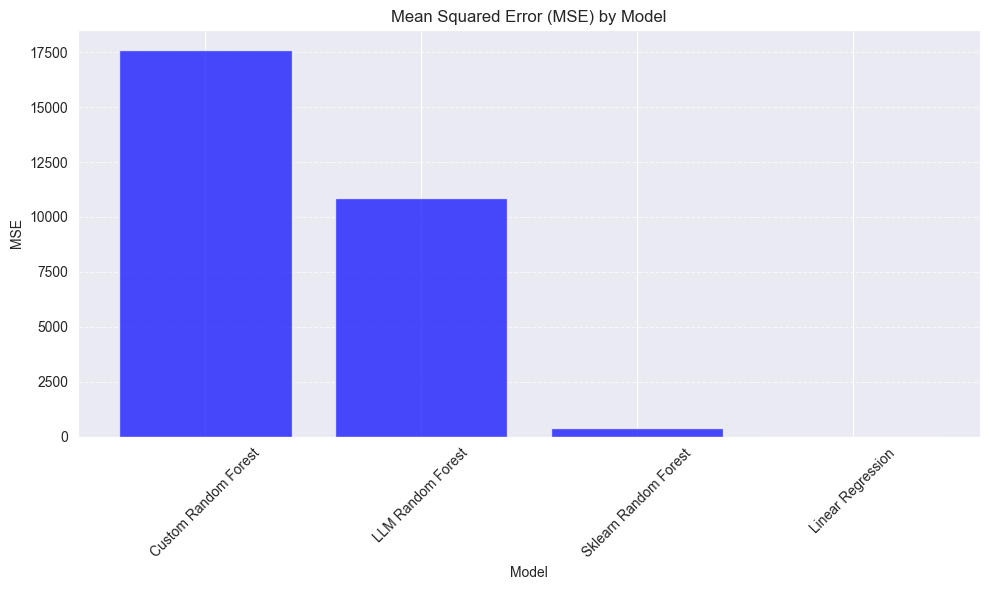

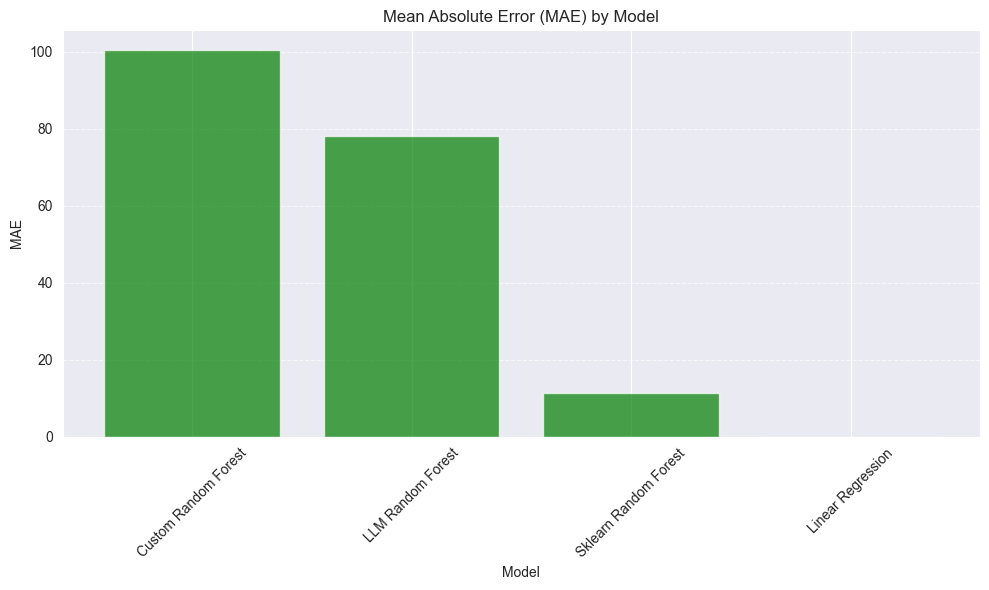

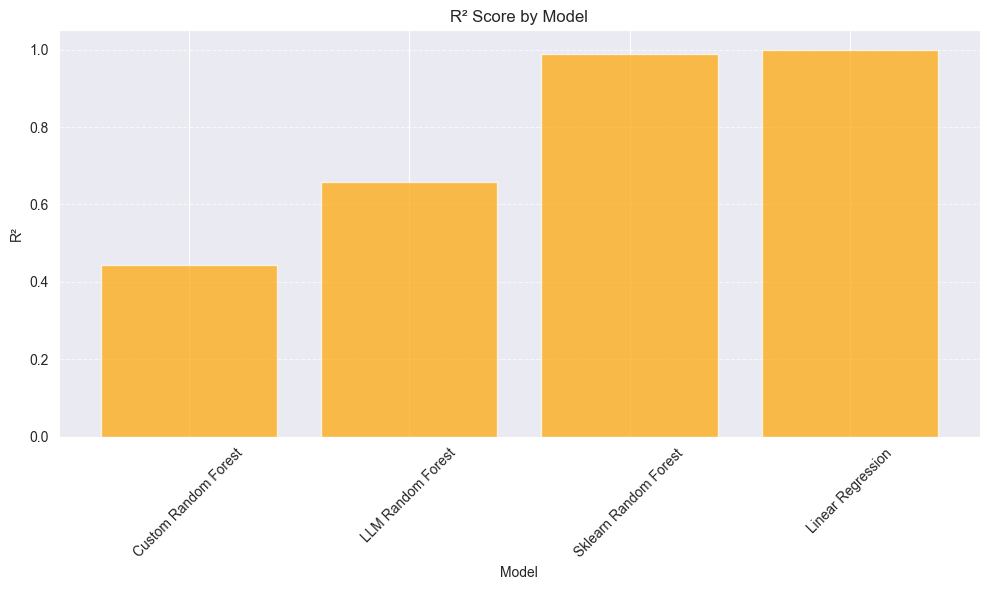

In [37]:
# df for visualization
metrics_flattened = {k: {metric: value for metric, value in v.items()} for k, v in test_results.items()}
test_results_flattened_df = pd.DataFrame.from_dict(metrics_flattened, orient='index')

#save to CSV
test_results_flattened_df.to_csv("detailed_test_results_bike_sharing_v2.csv", index=True)

print("\nTest Results Summary:")
print(test_results_flattened_df)

plot_results(test_results_flattened_df)